<center> <h1> Capstone Project_The Battle of the Neighborhoods_Week 2 </h1> </center>

<center> <h2> (Opening a Chinese Restaurant in Singapore) <h2> </center>

**Business Problem:** We assume that a stakeholder wants to open a Chinese restaurant in Singapore, and has not decided the location yet. He is not very familiar with the city and asked us to recommend neighbourhoods or locations where he should open his restaurant.

Certain considerations must be taken when choosing the ideal location:
* When exploring all the neighborhoods, choose one where the Chinese restaurants are not among the 10 most common businesses in the neighborhood.
* It would be ideal if the neighborhood has hotels which would indicate that there are many tourists around and people traveling for work, etc.
* The best 3 candidates who meet these requirements will be recommended.

## Table of Contents
* [1. Install and Import Libraries](#1)
* [2. Read Data into Pandas Dataframe](#2)
* [3. Creata a Map of Singapore with Planning Areas Superimposed on Top](#3)
* [4. Use Foursquare API to Explore Planning Areas](#4)
* [5. Analyze Each Planning Area](#5)
* [6. Cluster Planning Areas based on Data of Chinese Restaurants](#6)
* [7. Examine Clusters](#7)
* [8. Select Prime planning Areas to Open a Chinese Restaurant](#8)

<span id = '1'> <h1> 1. Install and Import Libraries </h1> </span> 

In [55]:

import numpy as np

import pandas as pd # library for data analsysis
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

import json # library to handle JSON files

!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values # to get coordinates

import requests # library to handle requests


from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!pip install folium
import folium # map rendering library

print("Libraries  are imported.")

Libraries  are imported.


<span id='2'> <h1> 2. Read Data into Pandas Dataframe </h1> </span> 

Singapore is divided into **Regions, Planning Areas and Subzones**. The Regions (total 5 regions) are divided into smaller Planning Areas (total 55 planning areas ). Each Planning Area is further divided into smaller Subzones (total more than 300). In this project **we will explore the neighbourhoods in the level of Planning Area**, i.e. we get the venue data around each Planning Area and select 3 Planning Areas as the 'best' locations to open a Chinese restaurant.

Data of Singapore Planning Area boundaries is available in the page https://data.gov.sg/dataset/master-plan-2019-planning-area-boundary-no-sea. I downloaded the original .kml file and transformed it into a .csv file, then the csv file was uploaded into Jupyter Notebook Labs.

In [56]:
# read the csv data into Pandas dataframe
df_source= pd.read_csv('planning-boundary-area.csv')
df_source.head()

,X,Y,gid,Name,description,PLN_AREA_N,PLN_AREA_C,CA_IND,REGION_N,REGION_C,INC_CRC,FMEL_UPD_D
0,103.793357,1.328117,3,kml_3,NaN,BUKIT TIMAH,BT,N,CENTRAL REGION,CR,6CCDADD1F85173E9,20191206144714
1,103.801664,1.376076,4,kml_4,NaN,CENTRAL WATER CATCHMENT,CC,N,NORTH REGION,NR,9F30125764C74984,20191206144714
2,103.748492,1.387486,6,kml_6,NaN,CHOA CHU KANG,CK,N,WEST REGION,WR,5224CD5C7960361F,20191206144714
3,104.049107,1.387936,14,kml_14,NaN,NORTH-EASTERN ISLANDS,NE,N,NORTH-EAST REGION,NER,E75708EADCFF04A6,20191206144714
4,103.725202,1.362108,34,kml_34,NaN,TENGAH,TH,N,WEST REGION,WR,0D2FF9150EC36DFE,20191206144714


In [57]:
# the features of the dataframe df_source
df_source.columns

Index(['X', 'Y', 'gid', 'Name', 'description', 'PLN_AREA_N', 'PLN_AREA_C',
       'CA_IND', 'REGION_N', 'REGION_C', 'INC_CRC', 'FMEL_UPD_D'],
      dtype='object')

In [58]:
# A new dataframe is created with features 'planning_area', 'region','latitude', 'longitude'
df_coord = pd.DataFrame(columns = ['planning_area', 'region','latitude', 'longitude'])

In [59]:
# We capture the useful data we need from the df_source dataframe and populate the data into df_coord dataframe
df_coord['planning_area'] = df_source['PLN_AREA_N']
df_coord['region'] = df_source['REGION_N']
df_coord['latitude'] = df_source['Y']
df_coord['longitude'] = df_source['X']
df_coord.head()

,planning_area,region,latitude,longitude
0,BUKIT TIMAH,CENTRAL REGION,1.328117,103.793357
1,CENTRAL WATER CATCHMENT,NORTH REGION,1.376076,103.801664
2,CHOA CHU KANG,WEST REGION,1.387486,103.748492
3,NORTH-EASTERN ISLANDS,NORTH-EAST REGION,1.387936,104.049107
4,TENGAH,WEST REGION,1.362108,103.725202


In [60]:
df_coord.shape

(55, 4)

In [61]:
df_coord.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55 entries, 0 to 54
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   planning_area  55 non-null     object 
 1   region         55 non-null     object 
 2   latitude       55 non-null     float64
 3   longitude      55 non-null     float64
dtypes: float64(2), object(2)
memory usage: 1.8+ KB


<span id='3'> <h1> 3. Creata a Map of Singapore with Planning Areas Superimposed on Top </h1> </span> 

We have already created a dataframe named df_coord which has information about planning areas and their corresponding coordinates, next we creat a map of Singapore with those planning areas sumperimposed on top.

In [62]:
# get the coordinates of Singapore

address= 'Singapore'

geolocator = Nominatim(user_agent = 'Singapore_explorer')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinates of Singapore {}, {}.'.format(latitude, longitude))

The geographical coordinates of Singapore 1.3408630000000001, 103.83039182212079.


In [63]:
# creat map of singapore using latitude and longitude values
map_singapore = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, planning_area in zip(df_coord['latitude'], df_coord['longitude'], df_coord['planning_area']):
    label = '{}'.format(planning_area)
    label = folium .Popup(label, parse_html=True)
    folium.CircleMarker(
    [lat, lng],
    radius =5,
    popup=label, color='blue',
    fill_color='#3186cc',
    fill_opicity=0.7).add_to(map_singapore)

map_singapore

<span id='4'> <h1> 4. Use Foursquare API to Explore Planning Areas </h1> </span> 

In [64]:
CLIENT_ID = 'GYL2VDJZZAPGN2GHCPZ2LAFL2WPVW5QJXKUQIHSEBKCAJKXO' # your Foursquare ID
CLIENT_SECRET = 'CNB3BKS33O5GSV2FBGXY1KSLA2PKQZUQLWPQOKXFSX4UAYPY' # your Foursquare Secret
VERSION = '20200807' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: GYL2VDJZZAPGN2GHCPZ2LAFL2WPVW5QJXKUQIHSEBKCAJKXO
CLIENT_SECRET:CNB3BKS33O5GSV2FBGXY1KSLA2PKQZUQLWPQOKXFSX4UAYPY


### Try with the first planning area on the list to explore nearby venues with Foursquare API for testing.

In [65]:
# Select the first planning area of the Dataframe.
df_coord.loc[0, 'planning_area']

'BUKIT TIMAH'

In [66]:
planning_area_latitude = df_coord.loc[0, 'latitude']
planning_area_longitude = df_coord.loc[0, 'longitude']

planning_area_name = df_coord.loc[0, 'planning_area']

print('Latitude and longitude values of {} are {}, {}.'.format(planning_area_name,
                                                               planning_area_latitude,
                                                               planning_area_longitude,
                                                               ))

Latitude and longitude values of BUKIT TIMAH are 1.3281168503763798, 103.79335705980101.


Now, we set the search parameters to explore venues in Foursquare API. A limit of 100 venues and a radius of 2000 meters.

In [67]:

LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 2000 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    planning_area_latitude, 
    planning_area_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=GYL2VDJZZAPGN2GHCPZ2LAFL2WPVW5QJXKUQIHSEBKCAJKXO&client_secret=CNB3BKS33O5GSV2FBGXY1KSLA2PKQZUQLWPQOKXFSX4UAYPY&v=20200807&ll=1.3281168503763798,103.79335705980101&radius=2000&limit=100'

In [68]:
# Using requests to get the list of venues in the neighborhood from the url.
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5f365a9fb0029033bd03cabd'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Bukit Timah',
  'headerFullLocation': 'Bukit Timah, Singapore',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 119,
  'suggestedBounds': {'ne': {'lat': 1.3461168683763978,
    'lng': 103.81132829758097},
   'sw': {'lat': 1.310116832376362, 'lng': 103.77538582202105}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '57c12529498e382e51d5bf3f',
       'name': 'Plank Sourdough Pizza By Baker & Cook',
       'location': {'address': '64 Namly Place',
        'lat': 1.323890345891065,
        'lng': 103.79679746827519,
        'labeledLatLngs': [{'label': 'dis

In [69]:

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [70]:
# Now we are ready to clean the json and structure it into a pandas dataframe.
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


,name,categories,lat,lng
0,Plank Sourdough Pizza By Baker & Cook,Pizza Place,1.323890,103.796797
1,Brazil Churrasco,Churrascaria,1.330798,103.795201
2,Ristorante Da Valentino,Italian Restaurant,1.336949,103.794060
3,MEAT n' CHILL,BBQ Joint,1.331425,103.794955
4,Sunny Heights,Dog Run,1.334700,103.794795


In [71]:
# print the number of venues found by Foursquare
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

100 venues were returned by Foursquare.


### Repeat the same process to all the planning areas in Singapore

In [72]:
    
    venues=[]
    for planning_area, lat, lng in zip(df_coord['planning_area'],df_coord['latitude'], df_coord['longitude']):
        print(planning_area)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        for venue in results:
            venues.append((
                planning_area,
                lat, 
                lng, 
                venue['venue']['name'], 
                venue['venue']['location']['lat'], 
                venue['venue']['location']['lng'],  
                venue['venue']['categories'][0]['name']))

BUKIT TIMAH
CENTRAL WATER CATCHMENT
CHOA CHU KANG
NORTH-EASTERN ISLANDS
TENGAH
PUNGGOL
BOON LAY
MARINA EAST
PIONEER
SEMBAWANG
SIMPANG
QUEENSTOWN
SELETAR
SOUTHERN ISLANDS
MARINA SOUTH
CHANGI BAY
TANGLIN
WESTERN ISLANDS
TUAS
DOWNTOWN CORE
NEWTON
ORCHARD
STRAITS VIEW
WOODLANDS
BUKIT MERAH
BUKIT PANJANG
LIM CHU KANG
CHANGI
CLEMENTI
HOUGANG
JURONG EAST
JURONG WEST
KALLANG
MANDAI
NOVENA
PASIR RIS
ANG MO KIO
BEDOK
BISHAN
BUKIT BATOK
SENGKANG
SERANGOON
SUNGEI KADUT
TAMPINES
TOA PAYOH
MUSEUM
OUTRAM
RIVER VALLEY
ROCHOR
SINGAPORE RIVER
MARINE PARADE
GEYLANG
PAYA LEBAR
WESTERN WATER CATCHMENT
YISHUN


In [73]:
# convert the venues list into a new DataFrame
venues_df = pd.DataFrame(venues)

# define the column names
venues_df.columns = ['planning_area', 'latitude', 'longitude', 'venue_name', 'venue_atitude', 'venue_longitude', 'venue_category']

print(venues_df.shape)
venues_df.head()

(3405, 7)


,planning_area,latitude,longitude,venue_name,venue_atitude,venue_longitude,venue_category
0,BUKIT TIMAH,1.328117,103.793357,Plank Sourdough Pizza By Baker & Cook,1.323890,103.796797,Pizza Place
1,BUKIT TIMAH,1.328117,103.793357,Brazil Churrasco,1.330798,103.795201,Churrascaria
2,BUKIT TIMAH,1.328117,103.793357,Ristorante Da Valentino,1.336949,103.794060,Italian Restaurant
3,BUKIT TIMAH,1.328117,103.793357,MEAT n' CHILL,1.331425,103.794955,BBQ Joint
4,BUKIT TIMAH,1.328117,103.793357,Sunny Heights,1.334700,103.794795,Dog Run


Let's check how many venues were returned for each planning area

In [74]:
venues_df.groupby(["planning_area"]).count()

,latitude,longitude,venue_name,venue_atitude,venue_longitude,venue_category
planning_area,,,,,,
ANG MO KIO,100,100,100,100,100,100
BEDOK,35,35,35,35,35,35
BISHAN,100,100,100,100,100,100
BOON LAY,20,20,20,20,20,20
BUKIT BATOK,96,96,96,96,96,96
BUKIT MERAH,100,100,100,100,100,100
BUKIT PANJANG,93,93,93,93,93,93
BUKIT TIMAH,100,100,100,100,100,100
CENTRAL WATER CATCHMENT,5,5,5,5,5,5


Let's find out how many unique categories can be curated from all the returned venues.

In [75]:
print('There are {} uniques categories.'.format(len(venues_df['venue_category'].unique())))

There are 295 uniques categories.


In [76]:
# print out the list of categories
venues_df['venue_category'].unique()[:50]

array(['Pizza Place', 'Churrascaria', 'Italian Restaurant', 'BBQ Joint',
       'Dog Run', 'Bakery', 'Soccer Field', 'Pet Service',
       'Historic Site', 'Go Kart Track', 'Japanese Restaurant', 'Café',
       'Spa', 'Supermarket', 'Ramen Restaurant', 'Trail',
       'Indian Restaurant', 'Bistro', 'Malay Restaurant',
       'Ice Cream Shop', 'French Restaurant', 'Farmers Market',
       'Restaurant', 'Wine Bar', 'Shabu-Shabu Restaurant',
       'Thai Restaurant', 'Stables', 'Bar', 'Dessert Shop',
       'Paella Restaurant', 'Golf Course', 'Shopping Mall',
       'Chinese Restaurant', 'Food Court', 'Asian Restaurant', 'Pool',
       'Cosmetics Shop', 'Seafood Restaurant', 'Dim Sum Restaurant',
       'Lounge', 'Steakhouse', 'Gourmet Shop', 'Pharmacy', 'Coffee Shop',
       'Sandwich Place', 'Sushi Restaurant', 'Grocery Store',
       'Frozen Yogurt Shop', 'Bookstore', 'Fruit & Vegetable Store'],
      dtype=object)

<span id='5'> <h1> 5. Analyze Each Planning Area </h1> </span> 

In [77]:

# one hot encoding
singapore_onehot = pd.get_dummies(venues_df[['venue_category']], prefix="", prefix_sep="")

# add planning_area column back to dataframe
singapore_onehot['planning_area'] = venues_df['planning_area'] 

# move planning_area column to the first column
fixed_columns=[singapore_onehot.columns[-1]] + list(singapore_onehot.columns[:-1])
singapore_onehot = singapore_onehot[fixed_columns]

print(singapore_onehot.shape)
singapore_onehot.head()

(3405, 296)


,planning_area,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Aquarium,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Garage,BBQ Joint,Bagel Shop,Bakery,Bar,Baseball Field,Basketball Court,Bay,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bike Trail,Bistro,Boarding House,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buddhist Temple,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Campground,Canal,Candy Store,Cantonese Restaurant,Cemetery,Cha Chaan Teng,Cheese Shop,Chinese Breakfast Place,Chinese Restaurant,Chocolate Shop,Church,Churrascaria,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Auditorium,College Cafeteria,College Gym,College Theater,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Dumpling Restaurant,Electronics Store,English Restaurant,Event Space,Exhibit,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Fishing Spot,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Fujian Restaurant,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,General Entertainment,German Restaurant,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Hainan Restaurant,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Health Food Store,High School,Hill,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hong Kong Restaurant,Hookah Bar,Hostel,Hot Spring,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Indoor Play Area,Island,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Light Rail Station,Lighthouse,Lingerie Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Military Base,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Mountain,Movie Theater,Moving Target,Multiplex,Museum,Music Venue,Nature Preserve,New American Restaurant,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Other Great Outdoors,Outdoor Sculpture,Paella Restaurant,Paper / Office Supplies Store,Park,Parking,Pedestrian Plaza,Peking Duck Restaurant,Performing Arts Venue,Persian Restaurant,Pet Service,Pet Store,Pharmacy,Pie Shop,Pier,Pizza Place,Planetarium,Playground,Plaza,Pool,Pool Hall,Port,Portuguese Restaurant,Pub,Public Art,Racetrack,Ramen Restaurant,Recreation Center,Reservoir,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,Rock Climbing Spot,Roof Deck,Sake Bar,Salad Place,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shaanxi Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Ski Area,Ski Chalet,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South Indian Restaurant,Souvenir Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stables,Stadium,Steakhouse,Street Food Gathering,Supermarket,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Track,Track Stadium,Trail,Train Station,Tunnel,Vegetarian / Vegan Restaurant,Video Game Store,Vie

Next, let's group rows by planning area and by taking the mean of the frequency of occurrence of each category

In [78]:
singapore_grouped = singapore_onehot.groupby(["planning_area"]).mean().reset_index()

print(singapore_grouped.shape)
singapore_grouped

(55, 296)


,planning_area,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Aquarium,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Garage,BBQ Joint,Bagel Shop,Bakery,Bar,Baseball Field,Basketball Court,Bay,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bike Trail,Bistro,Boarding House,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buddhist Temple,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Campground,Canal,Candy Store,Cantonese Restaurant,Cemetery,Cha Chaan Teng,Cheese Shop,Chinese Breakfast Place,Chinese Restaurant,Chocolate Shop,Church,Churrascaria,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Auditorium,College Cafeteria,College Gym,College Theater,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Dumpling Restaurant,Electronics Store,English Restaurant,Event Space,Exhibit,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Fishing Spot,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Fujian Restaurant,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,General Entertainment,German Restaurant,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Hainan Restaurant,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Health Food Store,High School,Hill,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hong Kong Restaurant,Hookah Bar,Hostel,Hot Spring,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Indoor Play Area,Island,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Light Rail Station,Lighthouse,Lingerie Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Military Base,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Mountain,Movie Theater,Moving Target,Multiplex,Museum,Music Venue,Nature Preserve,New American Restaurant,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Other Great Outdoors,Outdoor Sculpture,Paella Restaurant,Paper / Office Supplies Store,Park,Parking,Pedestrian Plaza,Peking Duck Restaurant,Performing Arts Venue,Persian Restaurant,Pet Service,Pet Store,Pharmacy,Pie Shop,Pier,Pizza Place,Planetarium,Playground,Plaza,Pool,Pool Hall,Port,Portuguese Restaurant,Pub,Public Art,Racetrack,Ramen Restaurant,Recreation Center,Reservoir,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,Rock Climbing Spot,Roof Deck,Sake Bar,Salad Place,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shaanxi Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Ski Area,Ski Chalet,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South Indian Restaurant,Souvenir Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stables,Stadium,Steakhouse,Street Food Gathering,Supermarket,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Track,Track Stadium,Trail,Train Station,Tunnel,Vegetarian / Vegan Restaurant,Video Game Store,Vie

Let's print each planning area along with the top 5 most common venues

In [79]:
num_top_venues = 5

for hood in singapore_grouped['planning_area']:
    print("----"+hood+"----")
    temp = singapore_grouped[singapore_grouped['planning_area'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----ANG MO KIO----
                  venue  freq
0            Food Court  0.14
1    Chinese Restaurant  0.09
2           Coffee Shop  0.06
3                  Café  0.05
4  Fast Food Restaurant  0.04


----BEDOK----
                venue  freq
0  Chinese Restaurant  0.14
1  Seafood Restaurant  0.11
2               Beach  0.09
3    Asian Restaurant  0.09
4     Harbor / Marina  0.06


----BISHAN----
                venue  freq
0  Chinese Restaurant  0.12
1         Coffee Shop  0.07
2                Café  0.05
3          Food Court  0.04
4         Supermarket  0.04


----BOON LAY----
             venue  freq
0          Exhibit  0.15
1  Harbor / Marina  0.10
2   Scenic Lookout  0.10
3      Zoo Exhibit  0.10
4        BBQ Joint  0.05


----BUKIT BATOK----
                  venue  freq
0            Food Court  0.12
1           Coffee Shop  0.11
2    Chinese Restaurant  0.07
3  Fast Food Restaurant  0.06
4           Supermarket  0.04


----BUKIT MERAH----
                venue  freq
0          

Let's put that into a pandas dataframe

In [80]:
# First, let's write a function to sort the venues in descending order.

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [81]:
# Now let's create the new dataframe and display the top 10 venues for each planning area.
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['planning_area']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
planningarea_venues_sorted = pd.DataFrame(columns=columns)
planningarea_venues_sorted['planning_area'] = singapore_grouped['planning_area']

for ind in np.arange(singapore_grouped.shape[0]):
    planningarea_venues_sorted.iloc[ind, 1:] = return_most_common_venues(singapore_grouped.iloc[ind, :], num_top_venues)

planningarea_venues_sorted.head()


,planning_area,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ANG MO KIO,Food Court,Chinese Restaurant,Coffee Shop,Café,Park,Fast Food Restaurant,Noodle House,Japanese Restaurant,Asian Restaurant,Gym
1,BEDOK,Chinese Restaurant,Seafood Restaurant,Beach,Asian Restaurant,Harbor / Marina,Bus Station,Wings Joint,Pool,Skate Park,Campground
2,BISHAN,Chinese Restaurant,Coffee Shop,Café,Food Court,Park,Supermarket,Japanese Restaurant,Thai Restaurant,Ice Cream Shop,Spa
3,BOON LAY,Exhibit,Zoo Exhibit,Scenic Lookout,Harbor / Marina,Smoke Shop,Other Great Outdoors,BBQ Joint,Café,Park,Fishing Spot
4,BUKIT BATOK,Food Court,Coffee Shop,Chinese Restaurant,Fast Food Restaurant,Supermarket,Café,Shopping Mall,Italian Restaurant,Sandwich Place,Malay Restaurant


<span id='6'> <h1> 6. Cluster Planning Areas based on Data of Chinese Restaurants </h1> </span> 

In [82]:
print(singapore_grouped.shape)
singapore_grouped.head()

(55, 296)


,planning_area,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Aquarium,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Garage,BBQ Joint,Bagel Shop,Bakery,Bar,Baseball Field,Basketball Court,Bay,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bike Trail,Bistro,Boarding House,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buddhist Temple,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Campground,Canal,Candy Store,Cantonese Restaurant,Cemetery,Cha Chaan Teng,Cheese Shop,Chinese Breakfast Place,Chinese Restaurant,Chocolate Shop,Church,Churrascaria,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Auditorium,College Cafeteria,College Gym,College Theater,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Dumpling Restaurant,Electronics Store,English Restaurant,Event Space,Exhibit,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Fishing Spot,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Fujian Restaurant,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,General Entertainment,German Restaurant,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Hainan Restaurant,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Health Food Store,High School,Hill,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hong Kong Restaurant,Hookah Bar,Hostel,Hot Spring,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Indoor Play Area,Island,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Light Rail Station,Lighthouse,Lingerie Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Military Base,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Mountain,Movie Theater,Moving Target,Multiplex,Museum,Music Venue,Nature Preserve,New American Restaurant,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Other Great Outdoors,Outdoor Sculpture,Paella Restaurant,Paper / Office Supplies Store,Park,Parking,Pedestrian Plaza,Peking Duck Restaurant,Performing Arts Venue,Persian Restaurant,Pet Service,Pet Store,Pharmacy,Pie Shop,Pier,Pizza Place,Planetarium,Playground,Plaza,Pool,Pool Hall,Port,Portuguese Restaurant,Pub,Public Art,Racetrack,Ramen Restaurant,Recreation Center,Reservoir,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,Rock Climbing Spot,Roof Deck,Sake Bar,Salad Place,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shaanxi Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Ski Area,Ski Chalet,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South Indian Restaurant,Souvenir Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stables,Stadium,Steakhouse,Street Food Gathering,Supermarket,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Track,Track Stadium,Trail,Train Station,Tunnel,Vegetarian / Vegan Restaurant,Video Game Store,Vie

In [83]:
len(singapore_grouped[singapore_grouped["Chinese Restaurant"] > 0])

33

Create a new DataFrame for Chinese Restaurant data only

In [84]:
ChineseRes_grouped = singapore_grouped[["planning_area","Chinese Restaurant"]]
ChineseRes_grouped.head()

,planning_area,Chinese Restaurant
0,ANG MO KIO,0.090000
1,BEDOK,0.142857
2,BISHAN,0.120000
3,BOON LAY,0.000000
4,BUKIT BATOK,0.072917


Now we need execute the Elbow Method to find the optimal number of clusters for K-Means algorithm.

In [85]:
clusters = pd.DataFrame()
clusters['cluster_range'] = range(1, 10)
inertia = []

In [86]:
ChineseRes_grouped_clustering = ChineseRes_grouped.drop('planning_area', 1)

for k in clusters['cluster_range']:
  kmeans = KMeans(n_clusters=k, random_state=8).fit(ChineseRes_grouped_clustering)
  inertia.append(kmeans.inertia_)

In [87]:
# Now we can use our list of inertia values in the clusters DataFrame:

clusters['inertia'] = inertia
clusters

,cluster_range,inertia
0,1,0.096768
1,2,0.029358
2,3,0.010084
3,4,0.005466
4,5,0.003008
5,6,0.002020
6,7,0.001168
7,8,0.000811
8,9,0.000654


In [88]:
clusters.set_index('cluster_range', inplace=True)
clusters

,inertia
cluster_range,
1,0.096768
2,0.029358
3,0.010084
4,0.005466
5,0.003008
6,0.002020
7,0.001168
8,0.000811
9,0.000654


<AxesSubplot:xlabel='cluster_range'>

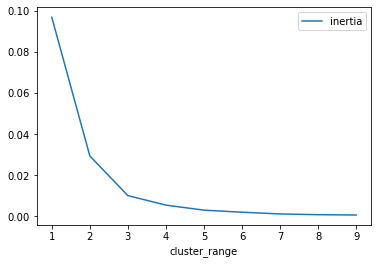

In [89]:
clusters.plot()

Based on Elbow Method, when k =2, the plot shows an obvious 'Elbow'. But we want the data to be splited into more clusters, so that we can reduce the data range from which we select the prime locations. **So we decide to set k=3**, which also show an 'Elbow' on the plot. 

In [90]:

# set number of clusters
kclusters= 3

ChineseRes_grouped_clustering = ChineseRes_grouped.drop('planning_area', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(ChineseRes_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:30]

array([1, 1, 1, 0, 2, 2, 0, 2, 0, 2, 0, 2, 2, 0, 1, 1, 2, 2, 2, 0, 2, 0,
       0, 0, 0, 2, 0, 2, 0, 0], dtype=int32)

In [91]:
# add clustering labels
planningarea_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)



# merge two dataframes into one single dataframe that includes the cluster as well as the top 10 venues for each planning area
planningarea_venues_sorted = df_coord.join(planningarea_venues_sorted.set_index('planning_area'), on='planning_area')

planningarea_venues_sorted.head()

,planning_area,region,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,BUKIT TIMAH,CENTRAL REGION,1.328117,103.793357,2,Bakery,Chinese Restaurant,Café,Italian Restaurant,Pizza Place,Soccer Field,Japanese Restaurant,Ice Cream Shop,Supermarket,Indian Restaurant
1,CENTRAL WATER CATCHMENT,NORTH REGION,1.376076,103.801664,0,Bridge,Park,Reservoir,Rest Area,Boat or Ferry,Flower Shop,Filipino Restaurant,Fish & Chips Shop,Fish Market,Fishing Spot
2,CHOA CHU KANG,WEST REGION,1.387486,103.748492,2,Coffee Shop,Fast Food Restaurant,Asian Restaurant,Food Court,Sushi Restaurant,Café,Supermarket,Chinese Restaurant,Park,Sandwich Place
3,NORTH-EASTERN ISLANDS,NORTH-EAST REGION,1.387936,104.049107,0,Asian Restaurant,Campground,Gun Range,Military Base,Zoo Exhibit,Fish & Chips Shop,Fish Market,Fishing Spot,Flea Market,Flower Shop
4,TENGAH,WEST REGION,1.362108,103.725202,0,Food Court,Asian Restaurant,Coffee Shop,Airport,Indian Restaurant,Gas Station,Café,Fast Food Restaurant,Chinese Restaurant,Stadium


In [92]:

Chinese_merged = ChineseRes_grouped.copy()

# add clustering labels
Chinese_merged["Cluster Labels"] = kmeans.labels_

In [93]:
Chinese_merged.head()

,planning_area,Chinese Restaurant,Cluster Labels
0,ANG MO KIO,0.090000,1
1,BEDOK,0.142857,1
2,BISHAN,0.120000,1
3,BOON LAY,0.000000,0
4,BUKIT BATOK,0.072917,2


In [94]:
Chinese_merged = Chinese_merged.join(df_coord.set_index("planning_area"), on="planning_area")

print(Chinese_merged.shape)
Chinese_merged.head() # check the first rows!

(55, 6)


,planning_area,Chinese Restaurant,Cluster Labels,region,latitude,longitude
0,ANG MO KIO,0.090000,1,NORTH-EAST REGION,1.376729,103.842565
1,BEDOK,0.142857,1,EAST REGION,1.301108,103.944936
2,BISHAN,0.120000,1,CENTRAL REGION,1.355160,103.837734
3,BOON LAY,0.000000,0,WEST REGION,1.312923,103.698202
4,BUKIT BATOK,0.072917,2,WEST REGION,1.356029,103.752601


In [95]:
# check the last rows!
Chinese_merged.tail()

,planning_area,Chinese Restaurant,Cluster Labels,region,latitude,longitude
50,TUAS,0.000000,0,WEST REGION,1.276268,103.628906
51,WESTERN ISLANDS,0.000000,0,WEST REGION,1.224018,103.727146
52,WESTERN WATER CATCHMENT,0.000000,0,WEST REGION,1.384956,103.694919
53,WOODLANDS,0.026667,0,NORTH REGION,1.443618,103.787925
54,YISHUN,0.050000,2,NORTH REGION,1.419031,103.843395


In [96]:
print(Chinese_merged.shape)
Chinese_merged.sort_values(["Cluster Labels"], inplace=True)
Chinese_merged

(55, 6)


,planning_area,Chinese Restaurant,Cluster Labels,region,latitude,longitude
44,STRAITS VIEW,0.000000,0,CENTRAL REGION,1.246133,103.868795
42,SINGAPORE RIVER,0.000000,0,CENTRAL REGION,1.290871,103.840498
24,MUSEUM,0.000000,0,CENTRAL REGION,1.295972,103.847505
23,MARINE PARADE,0.000000,0,CENTRAL REGION,1.268724,103.913258
22,MARINA SOUTH,0.000000,0,CENTRAL REGION,1.251698,103.884283
21,MARINA EAST,0.000000,0,CENTRAL REGION,1.256292,103.892283
43,SOUTHERN ISLANDS,0.000000,0,CENTRAL REGION,1.229460,103.826155
19,LIM CHU KANG,0.000000,0,NORTH REGION,1.435699,103.716885
36,ROCHOR,0.010000,0,CENTRAL REGION,1.304995,103.854284
45,SUNGEI KADUT,0.000000,0,NORTH REGION,1.419650,103.755742


In [97]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Chinese_merged['latitude'], Chinese_merged['longitude'], Chinese_merged['planning_area'], Chinese_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<span id='7'> <h1> 7. Examine Clusters </h1> </span> 

### Cluster 0: 
This cluster has the lowest frequency of Chinese Restaurants, which will be an ideal cluster to open a Chinese Restaurant.

In [98]:
Chinese_merged.loc[Chinese_merged['Cluster Labels'] == 0]

,planning_area,Chinese Restaurant,Cluster Labels,region,latitude,longitude
44,STRAITS VIEW,0.000000,0,CENTRAL REGION,1.246133,103.868795
42,SINGAPORE RIVER,0.000000,0,CENTRAL REGION,1.290871,103.840498
24,MUSEUM,0.000000,0,CENTRAL REGION,1.295972,103.847505
23,MARINE PARADE,0.000000,0,CENTRAL REGION,1.268724,103.913258
22,MARINA SOUTH,0.000000,0,CENTRAL REGION,1.251698,103.884283
21,MARINA EAST,0.000000,0,CENTRAL REGION,1.256292,103.892283
43,SOUTHERN ISLANDS,0.000000,0,CENTRAL REGION,1.229460,103.826155
19,LIM CHU KANG,0.000000,0,NORTH REGION,1.435699,103.716885
36,ROCHOR,0.010000,0,CENTRAL REGION,1.304995,103.854284
45,SUNGEI KADUT,0.000000,0,NORTH REGION,1.419650,103.755742


### Cluster 1: 
This cluster has the highest frequency of Chinese Restaurants, which is not good locations to open a Chinese Restaurant.

In [99]:
Chinese_merged.loc[Chinese_merged['Cluster Labels'] == 1]

,planning_area,Chinese Restaurant,Cluster Labels,region,latitude,longitude
40,SERANGOON,0.110000,1,NORTH-EAST REGION,1.366010,103.867606
0,ANG MO KIO,0.090000,1,NORTH-EAST REGION,1.376729,103.842565
15,HOUGANG,0.090000,1,NORTH-EAST REGION,1.360946,103.888800
14,GEYLANG,0.100000,1,CENTRAL REGION,1.321163,103.889852
49,TOA PAYOH,0.160000,1,CENTRAL REGION,1.336457,103.862479
2,BISHAN,0.120000,1,CENTRAL REGION,1.355160,103.837734
1,BEDOK,0.142857,1,EAST REGION,1.301108,103.944936
38,SEMBAWANG,0.127273,1,NORTH REGION,1.457080,103.818933


### Cluster 2:
This cluster has the medium frequency of Chinese Restaurants, which is also not ideal cluster to open a Chinese Restaurant.

In [100]:
Chinese_merged.loc[Chinese_merged['Cluster Labels'] == 2]

,planning_area,Chinese Restaurant,Cluster Labels,region,latitude,longitude
47,TANGLIN,0.050000,2,CENTRAL REGION,1.307610,103.815114
39,SENGKANG,0.060000,2,NORTH-EAST REGION,1.388638,103.895550
46,TAMPINES,0.037037,2,EAST REGION,1.324290,103.968145
27,NOVENA,0.070000,2,CENTRAL REGION,1.326091,103.837228
35,RIVER VALLEY,0.030000,2,CENTRAL REGION,1.297884,103.836371
34,QUEENSTOWN,0.068182,2,CENTRAL REGION,1.276400,103.773753
33,PUNGGOL,0.060000,2,NORTH-EAST REGION,1.406764,103.913796
25,NEWTON,0.040000,2,CENTRAL REGION,1.308506,103.840985
20,MANDAI,0.054545,2,NORTH REGION,1.427104,103.812815
18,KALLANG,0.060000,2,CENTRAL REGION,1.312327,103.865107


<span id='8'> <h1> 8. Select Prime Planning Areas to Open a Chinese Retaurant </h1> </span> 

In [101]:
singapore_grouped_count = singapore_onehot.groupby('planning_area').sum().reset_index()
singapore_grouped_count.head()

,planning_area,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Aquarium,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Garage,BBQ Joint,Bagel Shop,Bakery,Bar,Baseball Field,Basketball Court,Bay,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bike Trail,Bistro,Boarding House,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buddhist Temple,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Campground,Canal,Candy Store,Cantonese Restaurant,Cemetery,Cha Chaan Teng,Cheese Shop,Chinese Breakfast Place,Chinese Restaurant,Chocolate Shop,Church,Churrascaria,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Auditorium,College Cafeteria,College Gym,College Theater,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Dumpling Restaurant,Electronics Store,English Restaurant,Event Space,Exhibit,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Fishing Spot,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Fujian Restaurant,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,General Entertainment,German Restaurant,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Hainan Restaurant,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Health Food Store,High School,Hill,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hong Kong Restaurant,Hookah Bar,Hostel,Hot Spring,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Indoor Play Area,Island,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Light Rail Station,Lighthouse,Lingerie Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Military Base,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Mountain,Movie Theater,Moving Target,Multiplex,Museum,Music Venue,Nature Preserve,New American Restaurant,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Other Great Outdoors,Outdoor Sculpture,Paella Restaurant,Paper / Office Supplies Store,Park,Parking,Pedestrian Plaza,Peking Duck Restaurant,Performing Arts Venue,Persian Restaurant,Pet Service,Pet Store,Pharmacy,Pie Shop,Pier,Pizza Place,Planetarium,Playground,Plaza,Pool,Pool Hall,Port,Portuguese Restaurant,Pub,Public Art,Racetrack,Ramen Restaurant,Recreation Center,Reservoir,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,Rock Climbing Spot,Roof Deck,Sake Bar,Salad Place,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shaanxi Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Ski Area,Ski Chalet,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South Indian Restaurant,Souvenir Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stables,Stadium,Steakhouse,Street Food Gathering,Supermarket,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Track,Track Stadium,Trail,Train Station,Tunnel,Vegetarian / Vegan Restaurant,Video Game Store,Vie

As discussed in the beginning of this project, it would be ideal if the neighborhood has hotels which would indicate that there are many tourists around and people traveling for work, etc. We will see which planning areas have more hotels.

Now, we need to create a dataframe with hotels.

In [102]:
Hotel = pd.DataFrame(singapore_grouped_count['Hotel'])

Hotel['planning_area'] = singapore_grouped_count['planning_area']

Hotel.rename(columns={0:'Hotel'}, inplace=True)

Hotel.head()

,Hotel,planning_area
0,0,ANG MO KIO
1,0,BEDOK
2,0,BISHAN
3,0,BOON LAY
4,0,BUKIT BATOK


We are going to sort to see which planning areas have more hotels.

In [103]:
Hotel_candidates = Hotel.sort_values(by='Hotel', ascending=False).reset_index(drop=True).head(10)
Hotel_candidates

,Hotel,planning_area
0,16,DOWNTOWN CORE
1,12,TANGLIN
2,11,MUSEUM
3,11,OUTRAM
4,10,ORCHARD
5,10,ROCHOR
6,10,NEWTON
7,9,NOVENA
8,8,RIVER VALLEY
9,6,SINGAPORE RIVER


Now, we need to create a dataframe with Chinese Restaurant.

In [104]:
ChineseRes = pd.DataFrame(singapore_grouped_count['Chinese Restaurant'])

ChineseRes['planning_area'] = singapore_grouped_count['planning_area']

ChineseRes.rename(columns={0:'Chinese Restaurant'}, inplace=True)

ChineseRes.head()

,Chinese Restaurant,planning_area
0,9,ANG MO KIO
1,5,BEDOK
2,12,BISHAN
3,0,BOON LAY
4,7,BUKIT BATOK


Now, we join the two dataframes into one dataframe.

In [105]:
ChineseRes_Hotel = ChineseRes.join(Hotel.set_index('planning_area'), on='planning_area')
ChineseRes_Hotel.head()

,Chinese Restaurant,planning_area,Hotel
0,9,ANG MO KIO,0
1,5,BEDOK,0
2,12,BISHAN,0
3,0,BOON LAY,0
4,7,BUKIT BATOK,0


In [106]:
# Sort data by 'Hotel' in descending order
ChineseRes_Hotel.sort_values(by = 'Hotel', ascending = False).head(10)

,Chinese Restaurant,planning_area,Hotel
13,0,DOWNTOWN CORE,16
47,5,TANGLIN,12
24,0,MUSEUM,11
29,0,OUTRAM,11
28,2,ORCHARD,10
36,1,ROCHOR,10
25,4,NEWTON,10
27,7,NOVENA,9
35,3,RIVER VALLEY,8
42,0,SINGAPORE RIVER,6


Now we know the planning areas which have the most hotels. Then we need to see which clusters those planning areas belong to.

In [107]:
# Join ChineseRes_Hotel dataframe with planningaera_venues_sorted dataframe, then we can see the culsters and the top 10 most common venues.
ChineseRes_Hotel = ChineseRes_Hotel.join(planningarea_venues_sorted.set_index('planning_area'), on='planning_area')
ChineseRes_Hotel.sort_values(by = 'Hotel', ascending=False).head(10)

,Chinese Restaurant,planning_area,Hotel,region,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,0,DOWNTOWN CORE,16,CENTRAL REGION,1.286587,103.856088,0,Hotel,Waterfront,Event Space,Japanese Restaurant,Shopping Mall,Italian Restaurant,Plaza,Buffet,Restaurant,Cocktail Bar
47,5,TANGLIN,12,CENTRAL REGION,1.307610,103.815114,2,Hotel,Chinese Restaurant,Garden,Japanese Restaurant,French Restaurant,Boutique,Park,Café,Bakery,Sushi Restaurant
24,0,MUSEUM,11,CENTRAL REGION,1.295972,103.847505,0,Hotel,Japanese Restaurant,Cocktail Bar,Wine Bar,Shopping Mall,Café,Arts & Crafts Store,Performing Arts Venue,Concert Hall,Coffee Shop
29,0,OUTRAM,11,CENTRAL REGION,1.281626,103.843701,0,Hotel,Japanese Restaurant,Gym / Fitness Center,Coffee Shop,Restaurant,Cocktail Bar,Korean Restaurant,Bar,Spanish Restaurant,Café
28,2,ORCHARD,10,CENTRAL REGION,1.304012,103.834065,0,Hotel,Japanese Restaurant,Shopping Mall,Bakery,Sushi Restaurant,Boutique,Clothing Store,Coffee Shop,Bubble Tea Shop,Cocktail Bar
36,1,ROCHOR,10,CENTRAL REGION,1.304995,103.854284,0,Hotel,Café,Coffee Shop,Indian Restaurant,Ice Cream Shop,Italian Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant,Bakery
25,4,NEWTON,10,CENTRAL REGION,1.308506,103.840985,2,Hotel,Shopping Mall,Japanese Restaurant,Clothing Store,Sushi Restaurant,Chinese Restaurant,Bakery,Cosmetics Shop,Coffee Shop,Supermarket
27,7,NOVENA,9,CENTRAL REGION,1.326091,103.837228,2,Hotel,Chinese Restaurant,Coffee Shop,Bakery,Dessert Shop,Flower Shop,Food Court,Café,Italian Restaurant,Noodle House
35,3,RIVER VALLEY,8,CENTRAL REGION,1.297884,103.836371,2,Hotel,Japanese Restaurant,Shopping Mall,Coffee Shop,Clothing Store,Sushi Restaurant,Wine Bar,Chinese Restaurant,Bakery,Cosmetics Shop
42,0,SINGAPORE RIVER,6,CENTRAL REGION,1.290871,103.840498,0,Japanese Restaurant,Hotel,Wine Bar,Bookstore,Cocktail Bar,Spanish Restaurant,Hotpot Restaurant,French Restaurant,Bar,Bistro


As can be seen from the above dataframe, there are 3 planning areas that belong to cluster 2. we can also notice that Chinese Restaurant is among the top 10 most common venues for those 3 planning areas. We have discussed in beginning of this project, one of the considerations when selecting the prime locations is the ones where the Chinese restaurants are not among the 10 most common businesses in the neighborhood. So we will delete those three planning areas.

In [108]:
ChineseRes_Hotel_Candidates = ChineseRes_Hotel.sort_values(by = 'Hotel', ascending=False).head(10)

# delete the rows belong to cluster 2
ChineseRes_Hotel_Candidates = ChineseRes_Hotel_Candidates[ChineseRes_Hotel_Candidates['Cluster Labels'] != 2] 

# we also drop the columns of latitude and longitude
ChineseRes_Hotel_Candidates.drop(columns =['latitude'],inplace=True) 
ChineseRes_Hotel_Candidates.drop(columns =['longitude'],inplace=True)

ChineseRes_Hotel_Candidates

,Chinese Restaurant,planning_area,Hotel,region,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,0,DOWNTOWN CORE,16,CENTRAL REGION,0,Hotel,Waterfront,Event Space,Japanese Restaurant,Shopping Mall,Italian Restaurant,Plaza,Buffet,Restaurant,Cocktail Bar
24,0,MUSEUM,11,CENTRAL REGION,0,Hotel,Japanese Restaurant,Cocktail Bar,Wine Bar,Shopping Mall,Café,Arts & Crafts Store,Performing Arts Venue,Concert Hall,Coffee Shop
29,0,OUTRAM,11,CENTRAL REGION,0,Hotel,Japanese Restaurant,Gym / Fitness Center,Coffee Shop,Restaurant,Cocktail Bar,Korean Restaurant,Bar,Spanish Restaurant,Café
28,2,ORCHARD,10,CENTRAL REGION,0,Hotel,Japanese Restaurant,Shopping Mall,Bakery,Sushi Restaurant,Boutique,Clothing Store,Coffee Shop,Bubble Tea Shop,Cocktail Bar
36,1,ROCHOR,10,CENTRAL REGION,0,Hotel,Café,Coffee Shop,Indian Restaurant,Ice Cream Shop,Italian Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant,Bakery
42,0,SINGAPORE RIVER,6,CENTRAL REGION,0,Japanese Restaurant,Hotel,Wine Bar,Bookstore,Cocktail Bar,Spanish Restaurant,Hotpot Restaurant,French Restaurant,Bar,Bistro


All the planning areas in the above figure are in Central Region and have no Chinese restaurants in the top 10 most common venues (For ORCHARD and ROCHOR, Chinese restaurants are within the 2000 meters radius but not in the top 10 list). **DOWNTOWN CORE, MUSEUM, and OUTRAM,** these three planning areas have many hotels around , but no Chinese restaurants in both top 10 list and 2000 meters radius, so these three planning areas are the most optimal locations to open Chinese Restaurants.


### DOWNTOWN CORE, MUSEUM, and OUTRAM are recommended to open Chinese Restaurants.

There are also some limitations of this project. Firstly, the venue data extracted from Foursquare is confined to the radius 2000 meters, which may not represent the characteristics the whole planning area perfectly. In addition, we didn’t consider the competition of other types of restaurants in each planning area. And except hotels, other types of entertainment venues which also appeal a large number of tourists are not taken into account. All those aspects can be improved in the future work.